# **Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms 
import torch.nn as nn  
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os

# **Data Visualization**

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      transforms.Resize(size = (64,64)),
])

transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      transforms.Resize(size = (64,64)),
])

In [4]:
trainset = torchvision.datasets.Flowers102(root = './data', split='train', download = True, transform = transform_train)
testset = torchvision.datasets.Flowers102(root = './data', split='test', download = True, transform = transform_test)

In [5]:
print(trainset)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./data
    split=train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
           )


In [6]:
print(testset)

Dataset Flowers102
    Number of datapoints: 6149
    Root location: ./data
    split=test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
           )


In [7]:

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [8]:
print(len(trainloader))

255


In [9]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 64, 64])
torch.Size([3, 64, 64])
3


In [10]:
img = images[1]
print(type(img))

<class 'torch.Tensor'>


In [11]:
npimg = img.numpy()
print(npimg.shape)
npimg = np.transpose(npimg, (1,2,0))
print(npimg.shape)

(3, 64, 64)
(64, 64, 3)


In [12]:
batch_size = 4

In [13]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5
  plt.figure(figsize = (batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


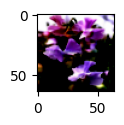

In [14]:
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()

In [15]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [str(x.item()) for x in labels])

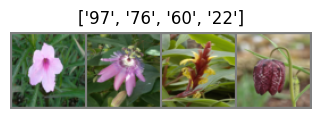

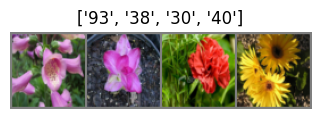

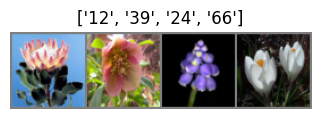

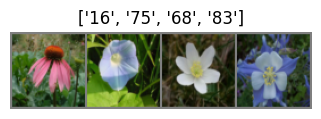

In [16]:
for i in range(4):
  show_batch_images(trainloader)

# **Data Pre Proccessing**

In [17]:
image_dims = (64, 64)
batch_size = 64

In [18]:
def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [19]:
class Dataset(torchvision.datasets.Flowers102):
  def __init__(self, path, image_dims = (64, 64), n_channels = 3, split='train'):
    super().__init__(path, split, download = True)
    self.n_classes = 102
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

  def Create_Mask(self, image):
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)
    x1, x2 = int(0.4*self.image_dims[0]), int(0.4*self.image_dims[0])
    y1, y2 = int(0.6*self.image_dims[1]), int(0.6*self.image_dims[1])
    thickness = -1
    cv2.rectangle(mask, (x1, x2), (y1, y2), (1, 1, 1), thickness)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

In [20]:
Trainset = Dataset('./data', image_dims)
Testset = Dataset('./data', image_dims, split='test')

In [21]:
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

In [22]:
Train_dataiter = iter(Trainloader)

In [23]:
Test_dataiter = iter(Testloader)

In [24]:
X_in, X_mask, Y_out = next(Train_dataiter)
print(X_in.shape, X_mask.shape, Y_out.shape)

torch.Size([64, 3, 64, 64]) torch.Size([64, 3, 64, 64]) torch.Size([64, 3, 64, 64])


Masked Image


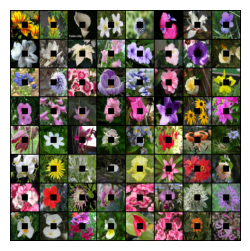

Masking Pattern


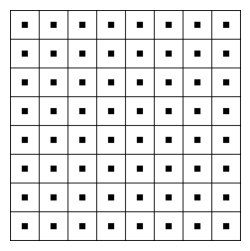

Original Image


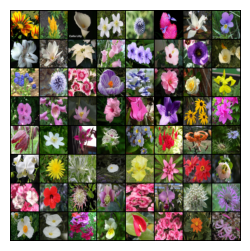

In [25]:
print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# **Training**

In [26]:
class PartialConv(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides=1, padding=0, dilation=1, groups=1, bias=True):
        super(PartialConv, self).__init__()

        padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.input_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=bias)
        self.mask_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=False)
        
        self.window_size = kernel_size[0] * kernel_size[1]

        nn.init.constant_(self.mask_conv.weight, 1.0)

        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        mask_ratio = self.window_size / (output_mask + 1e-8)

        output_mask = torch.clamp(output_mask, 0, 1)
  
        mask_ratio = mask_ratio * output_mask

        output = output * mask_ratio

        output = output + output_bias

        return output, output_mask

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(EncoderLayer, self).__init__()
        self.p_conv_1 = PartialConv(in_filters, out_filters, (3, 3), strides=1)
        self.act_1 = nn.ReLU()
        self.p_conv_2 = PartialConv(out_filters, out_filters, (3, 3), strides=2)
        self.act_2 = nn.ReLU()

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1 = self.p_conv_1(inputs, masks)
        conv_out_1 = self.act_1(conv_out_1)

        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, in_filters_1, in_filters_2):
        super(DecoderLayer, self).__init__()

        self.up_image = nn.Upsample(scale_factor=(2, 2))
        self.up_mask = nn.Upsample(scale_factor=(2, 2))
        
        self.p_conv_1 = PartialConv(in_filters_1 * 2, in_filters_1, (3, 3))
        self.act_1 = nn.LeakyReLU(negative_slope=0.2)
        self.p_conv_2 = PartialConv(in_filters_1, in_filters_2, (3, 3))
        self.act_2 = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, in_image, in_mask, share_image, share_mask):
        up_out = self.up_image(in_image)
        mask_out = self.up_mask(in_mask)

        concat_image = torch.cat([share_image, up_out], axis=1)
        concat_mask = torch.cat([share_mask, mask_out], axis=1)

        conv_out_1, mask_out_1 = self.p_conv_1(concat_image, concat_mask)
        conv_out_1 = self.act_1(conv_out_1)
    
        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [29]:
class InpaintingModel(nn.Module):
    def __init__(self, input_dims=(64, 64), num_channels=3):
        super(InpaintingModel, self).__init__()

        self.encoder_1 = EncoderLayer(num_channels, 32)
        self.encoder_2 = EncoderLayer(32, 64)
        self.encoder_3 = EncoderLayer(64, 128)
        self.encoder_4 = EncoderLayer(128, 256)

        self.decoder_1 = DecoderLayer(256, 128)
        self.decoder_2 = DecoderLayer(128, 64)
        self.decoder_3 = DecoderLayer(64, 32)
        self.decoder_4 = DecoderLayer(32, 3)

        self.output_layer = nn.Sequential(
            nn.Conv2d(3, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1, conv_out_2, mask_out_2 = self.encoder_1(inputs, masks)
        conv_out_3, mask_out_3, conv_out_4, mask_out_4 = self.encoder_2(conv_out_2, mask_out_2)
        conv_out_5, mask_out_5, conv_out_6, mask_out_6 = self.encoder_3(conv_out_4, mask_out_4)
        conv_out_7, mask_out_7, conv_out_8, mask_out_8 = self.encoder_4(conv_out_6, mask_out_6)

        conv_out_9, mask_out_9, conv_out_10, mask_out_10 = self.decoder_1(conv_out_8, mask_out_8, conv_out_7, mask_out_7)
        conv_out_11, mask_out_11, conv_out_12, mask_out_12 = self.decoder_2(conv_out_6, mask_out_6, conv_out_5, mask_out_5)
        conv_out_13, mask_out_13, conv_out_14, mask_out_14 = self.decoder_3(conv_out_4, mask_out_4, conv_out_3, mask_out_3)
        conv_out_15, mask_out_15, conv_out_16, mask_out_16 = self.decoder_4(conv_out_2, mask_out_2, conv_out_1, mask_out_1)

        outputs = self.output_layer(conv_out_16)
        return outputs

In [30]:
def jaccard_coeff(dataloader):
  for (X_input, X_mask, Y_output) in dataloader:
    X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)
    outputs = model(X_input, X_mask)
    eps = 1e-15
    outputs = outputs.view(-1)
    Y_output = Y_output.view(-1)
    intersection = (outputs * Y_output).sum()
    union = (outputs.sum() + Y_output.sum()) - intersection
  return (intersection / (union + eps))

In [31]:
model = InpaintingModel()
model = model.to(device)

In [32]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters())

Min loss 0.07592
Iteration: 0/1, Loss: 0.07592, Jaccard Coeff: 0.27831
Iteration: 0/1, Loss: 0.08074, Jaccard Coeff: 0.28573
Iteration: 0/1, Loss: 0.08491, Jaccard Coeff: 0.25620
Min loss 0.07488
Min loss 0.07329
Iteration: 0/1, Loss: 0.07457, Jaccard Coeff: 0.25928
Min loss 0.07186
Min loss 0.06734
Iteration: 0/1, Loss: 0.07619, Jaccard Coeff: 0.25538
Min loss 0.06532
Min loss 0.06438
Iteration: 0/1, Loss: 0.06804, Jaccard Coeff: 0.24753
Min loss 0.06314
Min loss 0.06253
Min loss 0.06118
Iteration: 0/1, Loss: 0.06262, Jaccard Coeff: 0.24918
Min loss 0.05780
Min loss 0.05775
Min loss 0.05767
Min loss 0.05736
Iteration: 0/1, Loss: 0.05736, Jaccard Coeff: 0.23192
Min loss 0.05653
Min loss 0.05522
Min loss 0.05277
Min loss 0.04815
Min loss 0.04689
Iteration: 0/1, Loss: 0.04689, Jaccard Coeff: 0.26938
Min loss 0.04429
Min loss 0.04275
Min loss 0.04030
Min loss 0.03936
Min loss 0.03617
Min loss 0.03325
Min loss 0.03169
Iteration: 0/1, Loss: 0.03169, Jaccard Coeff: 0.31513
Min loss 0.03101
M

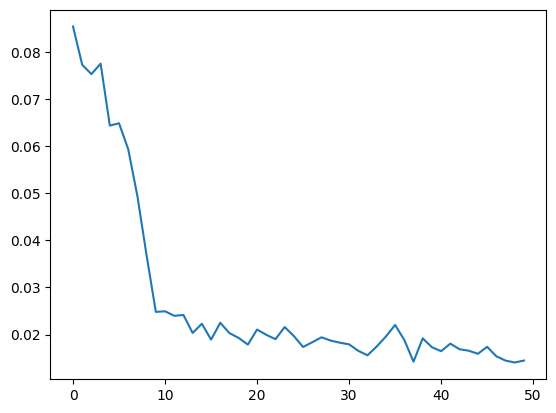

CPU times: total: 6min 30s
Wall time: 7min 8s


In [33]:
%%time
loss_epoch_arr = []
max_epochs = 50

min_loss = 1000

n_iters = np.ceil(len(Trainloader)/batch_size)
for epoch in range(max_epochs):
    model.train()                               
    for i, (X_input, X_mask, Y_output) in enumerate(Trainloader, 0):

        X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)

        opt.zero_grad()

        outputs = model(X_input, X_mask)
        loss = loss_fn(Y_output, outputs)
        loss.backward()

        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print('Min loss %0.5f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.5f, Jaccard Coeff: %0.5f' % (i, n_iters, loss.item(), jaccard_coeff(Trainloader)))

        del X_input, X_mask, Y_output
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())    

plt.plot(loss_epoch_arr)
plt.show()

In [34]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [35]:
print(model)

InpaintingModel(
  (encoder_1): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (act_2): ReLU()
  )
  (encoder_2): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fals

In [36]:
torch.save(model.state_dict(), './model.pt')

In [37]:
weight_layer0 = list(model.parameters())[0].cpu()
weight_layer0 = weight_layer0.data.numpy()

In [38]:
print(weight_layer0.shape)

(32, 3, 3, 3)


[]

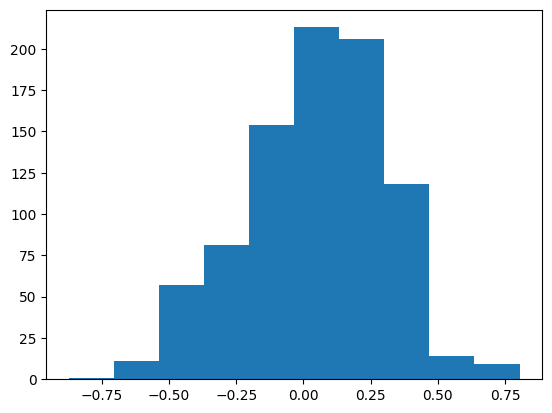

In [39]:
plt.hist(weight_layer0.ravel())
plt.plot()

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


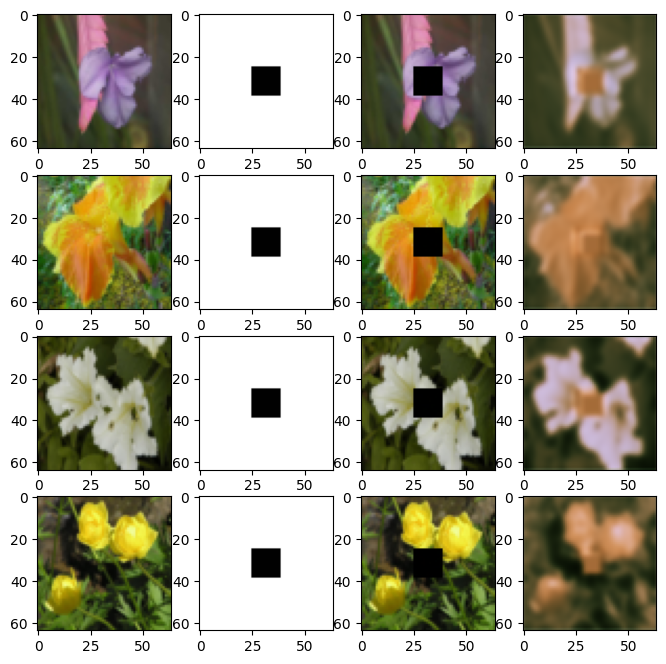

In [40]:
sample_inputs, sample_masks, sample_truths = next(Train_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)
    print(sample_inputs.size())
    print(sample_preds.size())

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))

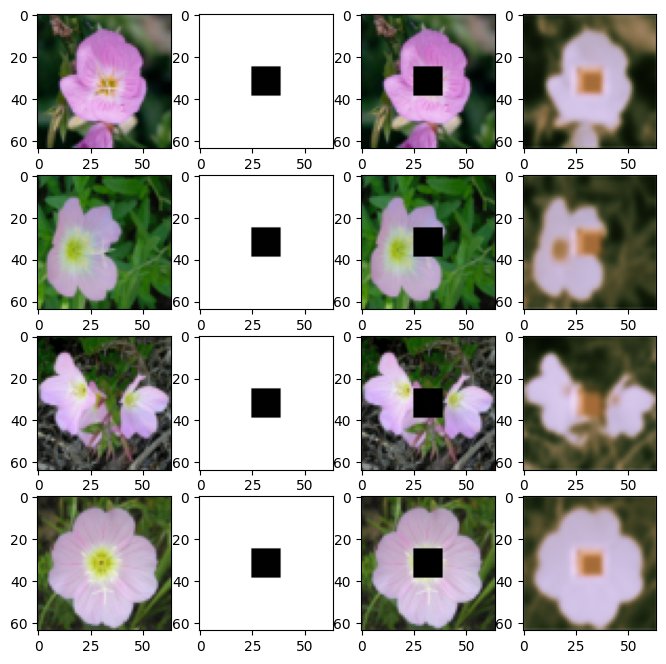

In [41]:
sample_inputs, sample_masks, sample_truths = next(Test_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))

In [42]:
# Call this to download the model weights
"""
model = InpaintingModel()
model.load_state_dict(torch.load('./model.pt'))
model.eval()
"""

"\nmodel = InpaintingModel()\nmodel.load_state_dict(torch.load('./model.pt'))\nmodel.eval()\n"